# Load media from S3 and other cloud storage

Import images, videos, and audio files from S3, GCS, HTTP URLs, or local paths into Pixeltable tables.

## Problem

You have media files stored in cloud storage (S3, GCS) or accessible via HTTP URLs. You need to process these files with AI models without downloading them all upfront.

| Source | Files | Challenge |
|--------|-------|-----------|
| s3://my-bucket/images/ | 100K images | Too large to download |
| https://cdn.example.com/ | 10K videos | Need lazy loading |
| gs://my-bucket/audio/ | 50K audio | Process incrementally |

## Solution

**What's in this recipe:**

- Reference media files by URL (S3, HTTP, local paths)
- Automatic caching of remote files on access
- Process files lazily without bulk downloads

You insert media URLs as references. Pixeltable stores the URLs and automatically downloads/caches files when you access them through queries or computed columns.

### Setup

In [ ]:
%pip install -qU pixeltable boto3

In [2]:
import pixeltable as pxt

In [3]:
# Create a fresh directory
pxt.drop_dir('cloud_demo', force=True)
pxt.create_dir('cloud_demo')

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/pjlb/.pixeltable/pgdata
Created directory 'cloud_demo'.


### Load images from HTTP URLs

Reference images by URL—Pixeltable downloads them on demand:

In [4]:
# Create a table with image column
images = pxt.create_table('cloud_demo.images', {'image': pxt.Image})

Created table 'images'.


In [5]:
# Insert images by URL (HTTP)
image_urls = [
    'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000036.jpg',
    'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000090.jpg',
    'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000106.jpg',
]

images.insert([{'image': url} for url in image_urls])

Inserting rows into `images`: 3 rows [00:00, 767.91 rows/s]
Inserted 3 rows with 0 errors.


3 rows inserted, 6 values computed.

image
""
""
""

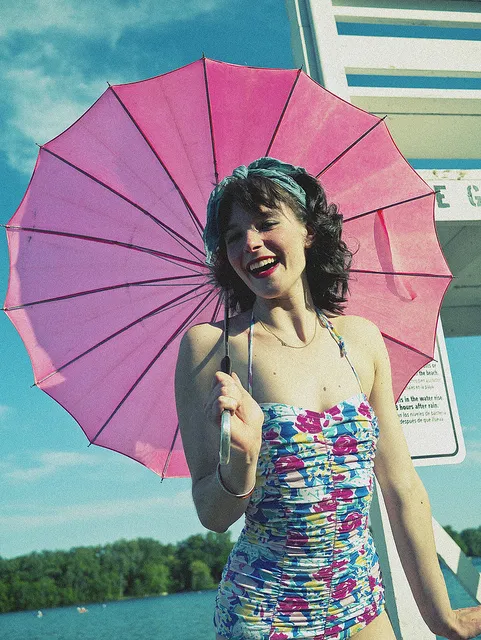
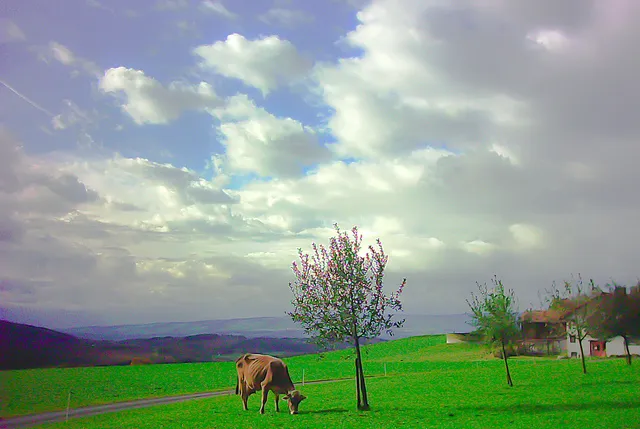
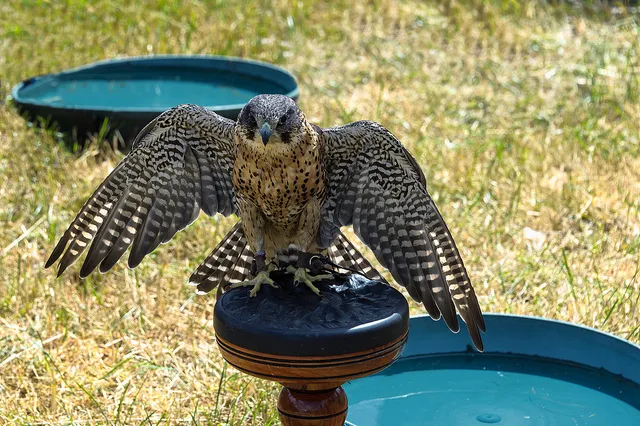

In [6]:
# View images - files are downloaded and cached on access
images.collect()

### Load videos from S3

Reference videos in S3 buckets (using public Multimedia Commons bucket):

In [7]:
# Create a table with video column
videos = pxt.create_table('cloud_demo.videos', {'video': pxt.Video})

Created table 'videos'.


In [8]:
# Insert videos by S3 URL (public bucket, no credentials needed)
s3_prefix = 's3://multimedia-commons/'
video_paths = [
    'data/videos/mp4/ffe/ffb/ffeffbef41bbc269810b2a1a888de.mp4',
    'data/videos/mp4/ffe/feb/ffefebb41485539f964760e6115fbc44.mp4',
]

videos.insert([{'video': s3_prefix + path} for path in video_paths])

Inserting rows into `videos`: 2 rows [00:00, 1477.13 rows/s]
Inserted 2 rows with 0 errors.


2 rows inserted, 4 values computed.

video
""
""

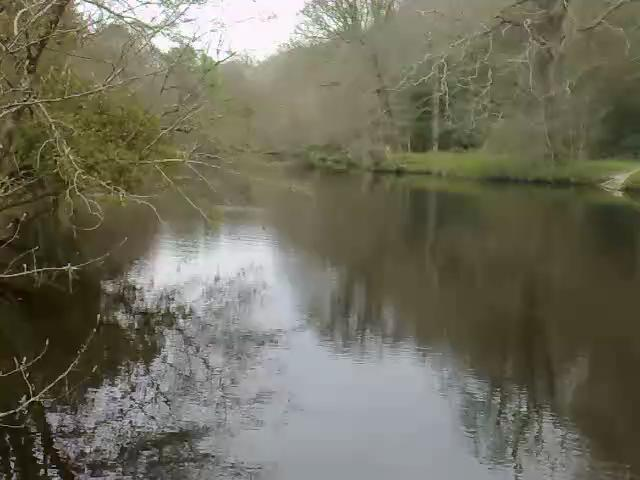
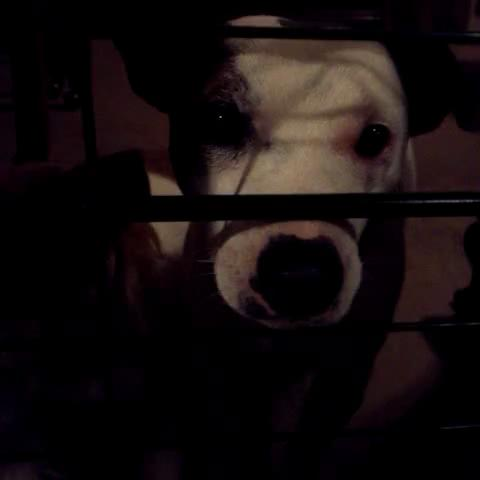

In [9]:
# View videos - downloaded and cached on access
videos.collect()

### Add computed columns on remote media

Process remote media with computed columns—files are fetched automatically:

In [10]:
# Add computed columns for image properties
images.add_computed_column(width=images.image.width)
images.add_computed_column(height=images.image.height)

Added 3 column values with 0 errors.
Added 3 column values with 0 errors.


3 rows updated, 6 values computed.

image,width,height
,481,640
,640,429
,640,426

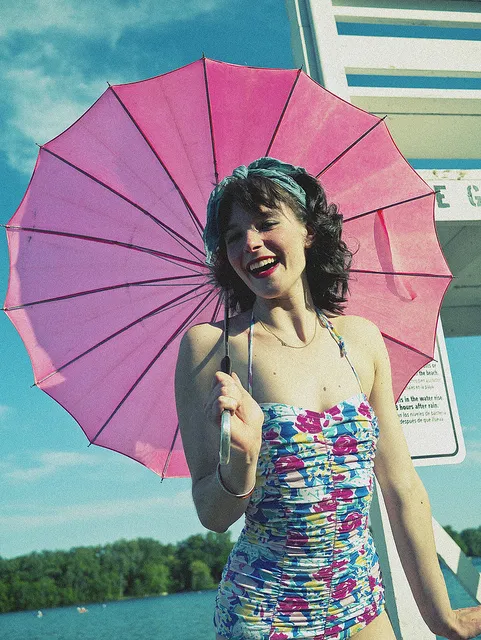
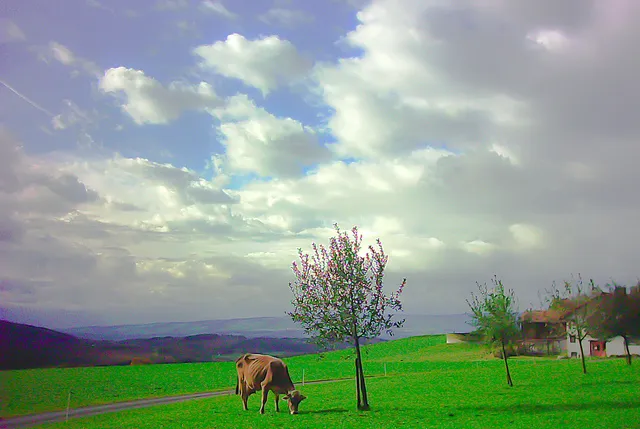
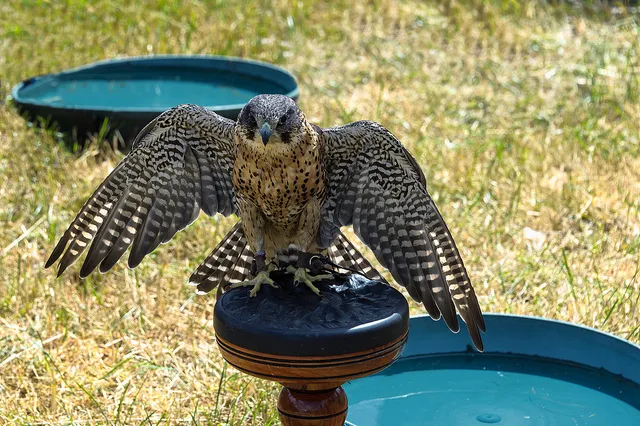

In [11]:
# View with computed properties
images.select(images.image, images.width, images.height).collect()

### Generate presigned URLs for serving media

When you store media in private cloud storage, you need presigned URLs to serve files over HTTP. The `presigned_url` function converts storage URIs to time-limited, publicly accessible URLs:

video,original_uri,http_url
,s3://multimedia-commons/data/videos/mp4/ffe/ffb/ffeffbef41bbc269810b2a1a888de.mp4,https://s3.us-west-2.amazonaws.com/multimedia-commons/data/videos/mp4/ffe/ffb/ffeffbef41bbc269810b2a1a888de.mp4
,s3://multimedia-commons/data/videos/mp4/ffe/feb/ffefebb41485539f964760e6115fbc44.mp4,https://s3.us-west-2.amazonaws.com/multimedia-commons/data/videos/mp4/ffe/feb/ffefebb41485539f964760e6115fbc44.mp4

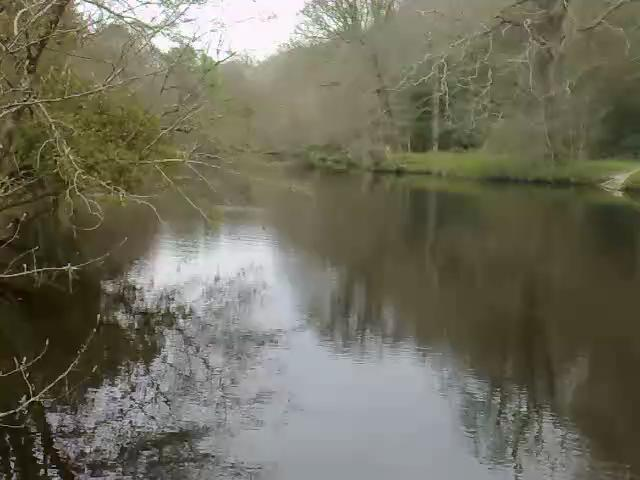
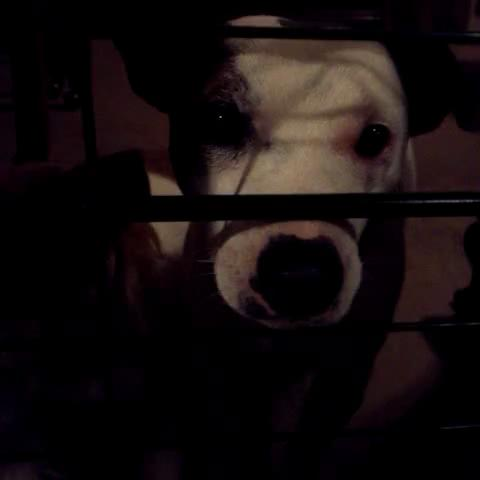

In [12]:
import pixeltable.functions as pxtf

# Generate presigned URLs for videos (1-hour expiration)
videos.select(
    videos.video,
    original_uri=videos.video.fileurl,
    http_url=pxtf.net.presigned_url(videos.video.fileurl, 3600)
).collect()


In [13]:
# Store presigned URLs as computed column for API responses
videos.add_computed_column(
    serving_url=pxtf.net.presigned_url(videos.video.fileurl, 86400)  # 24-hour expiration
)


Added 2 column values with 0 errors.


2 rows updated, 4 values computed.

**Use cases for presigned URLs:**

- Serve private media in web applications without exposing credentials
- Generate download links for end users
- Integrate with CDNs or video players that require HTTP URLs

**Provider limitations:**

| Provider | Max expiration |
|----------|----------------|
| AWS S3 | 7 days |
| Google Cloud Storage | 7 days |
| Azure Blob Storage | Depends on account policy |

Note: HTTP/HTTPS URLs pass through unchanged (already publicly accessible).

### Supported URL formats

Pixeltable supports multiple URL schemes for media files:

| Scheme | Example | Credentials |
|--------|---------|-------------|
| `http://` | `http://example.com/image.jpg` | None |
| `https://` | `https://cdn.example.com/video.mp4` | None |
| `s3://` | `s3://bucket/path/file.jpg` | AWS credentials\* |
| `gs://` | `gs://bucket/path/file.mp4` | GCP credentials\* |
| `file://` | `file:///path/to/file.jpg` | None |
| (local path) | `/path/to/file.jpg` | None |

\*Configure AWS/GCP credentials via environment variables or config files.

## Explanation

**How caching works:**

1. URLs are stored as references in the table
1. Files are downloaded on first access (query or computed column)
1. Downloaded files are cached in `~/.pixeltable/file_cache/`
1. Cache uses LRU eviction when space is needed

**Benefits of URL-based storage:**

- **Lazy loading** - Only download files when needed
- **Deduplication** - Same URL is cached once
- **Incremental processing** - Add files without bulk downloads
- **Cloud-native** - Works directly with object storage

**For private S3 buckets:**

Configure AWS credentials using standard methods:

- Environment variables (`AWS_ACCESS_KEY_ID`, `AWS_SECRET_ACCESS_KEY`)
- AWS credentials file (`~/.aws/credentials`)
- IAM roles (when running on EC2/ECS)

## See also

- [Extract frames from videos](https://docs.pixeltable.com/howto/cookbooks/video/video-extract-frames) - Process video files
- [Analyze images in batch](https://docs.pixeltable.com/howto/cookbooks/images/vision-batch-analysis) - AI vision on images
- [Configure API keys](https://docs.pixeltable.com/howto/cookbooks/core/workflow-api-keys) - Set up credentials